In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
# Dataset Directory
PATH = "../Dataset"

# Training Dataset Directory
DATA_DIR_TRAIN = "/Training Set"
# Testing Dataset Directory
DATA_DIR_TEST = "/Testing Set"

# full path
DATA_DIR_TRAIN = PATH + DATA_DIR_TRAIN
DATA_DIR_TEST = PATH + DATA_DIR_TEST

# List of training and validation patient list
train_val_patient_list = os.listdir(DATA_DIR_TRAIN)

#List of testing patients list
test_patient_list = os.listdir(DATA_DIR_TEST)

print(len(train_val_patient_list))
print(len(test_patient_list))

100
54


In [3]:
from sklearn.model_selection import train_test_split

# Spliting the training dataset to 80% training and 20% validation data
training_dir, validation_dir = train_test_split(train_val_patient_list, test_size=0.2, random_state=20)

print(len(training_dir))
print(len(validation_dir))

80
20


In [140]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    fig_image = plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        x = image
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(x)
    plt.show()
    fig_image.savefig('prediction.png')

In [72]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as transforms

In [73]:
class AtriaDataset(Dataset):
    def __init__(self, dataset_dir, patient_list, augmentation=None, preprocessing=None):
        
        self.patient_list = patient_list
        self.patient_path_list = sorted([os.path.join(dataset_dir, pid) 
                                         for pid in patient_list])
        self.image_folder_list = [os.path.join(patient_path, "Images") 
                                  for patient_path in self.patient_path_list]
        self.label_folder_list = [os.path.join(patient_path, "Labels") 
                                  for patient_path in self.patient_path_list]
        
        self.mri_image = []
        
        for file_name in self.image_folder_list:
            images = os.listdir(file_name)
            for img in images:
                self.mri_image.append(os.path.join(file_name, img))

        self.mri_image.sort()

        self.mask = []
        
        for file_name in self.label_folder_list:
            labels = os.listdir(file_name)
            for label in labels:
                self.mask.append(os.path.join(file_name, label))

        self.mask.sort()
        
        self.full_list = sorted((self.mri_image[i], self.mask[i]) 
                                for i in range(len(self.mri_image)))
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.data_size = len(self.full_list)
    
    
    def __getitem__(self, index):
        
        image = cv2.imread(self.full_list[index][0],0)
        mask = cv2.imread(self.full_list[index][1],0)
        image = cv2.resize(image, (576,576), interpolation = cv2.INTER_AREA)
        mask = cv2.resize(mask, (576,576), interpolation = cv2.INTER_AREA)
        image = image[:, :, np.newaxis]
        mask = mask[:, :, np.newaxis]
        #print(mask.shape)
        
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
    
    
    def __len__(self):
        return self.data_size

0 195 (576, 576, 1) <class 'numpy.ndarray'>
0 255 (576, 576, 1) <class 'numpy.ndarray'>


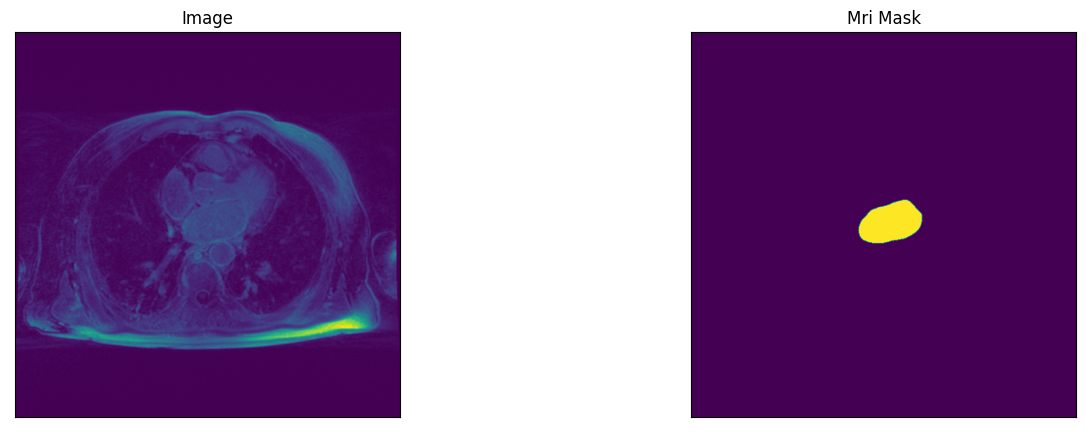

In [74]:
train_dataset = AtriaDataset(DATA_DIR_TRAIN, training_dir)

image, mask = train_dataset[131]
print(np.min(image), np.max(image), image.shape, type(image))
print(np.min(mask), np.max(mask), mask.shape, type(mask))

visualize(
    image=image, 
    mri_mask=mask
)

In [75]:
import albumentations as albu

In [121]:
def get_training_augmentation():
    train_transform = [
        albu.CenterCrop(width=256, height=256),
        albu.HorizontalFlip(p=0.8),
        albu.ShiftScaleRotate(scale_limit=0.5, shift_limit=0.0625, rotate_limit=45, p=0.2),
        albu.RandomContrast(p=0.8),
        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),
        
        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    #print(type(x))
    return x.transpose(2, 0, 1).astype('float32')

def conv_mask(x, **kwargs):
    thresh, img = cv2.threshold(x,128,255,cv2.THRESH_BINARY)
    img = img/255
    img = np.expand_dims(img, axis=2)
    return img

def std_norm_image(x, **kwargs):
    x = x/255
    mean=0.485
    std=0.229
    x = (x - mean)/std
    return x

def norm_image(x, **kwargs):
    x = x/255
    return x


def get_preprocessing():
    _transform = [
        albu.Lambda(image=std_norm_image),
        albu.Lambda(mask=conv_mask),
        albu.Lambda(image=to_tensor, mask=to_tensor)
    ]
    return albu.Compose(_transform)

0 144 (256, 256, 1) <class 'numpy.ndarray'>
0 255 (256, 256, 1) <class 'numpy.ndarray'>


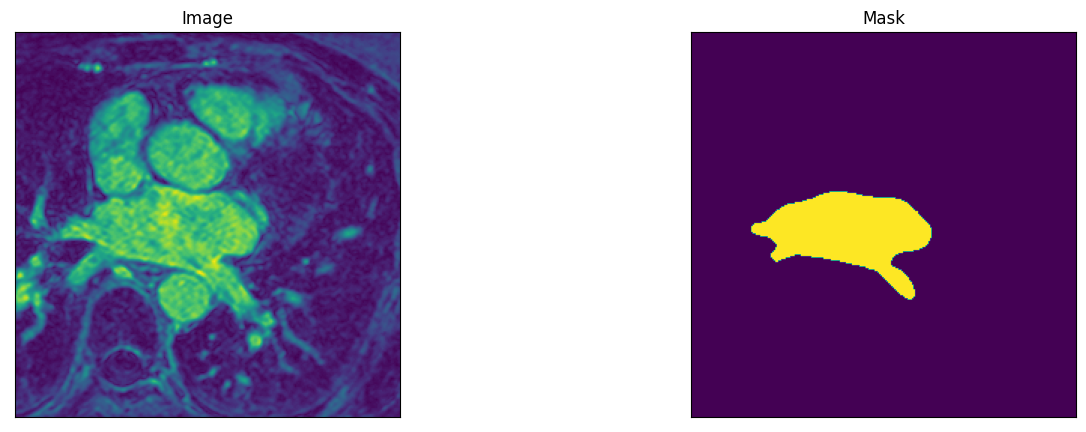

1 137 (256, 256, 1) <class 'numpy.ndarray'>
0 255 (256, 256, 1) <class 'numpy.ndarray'>


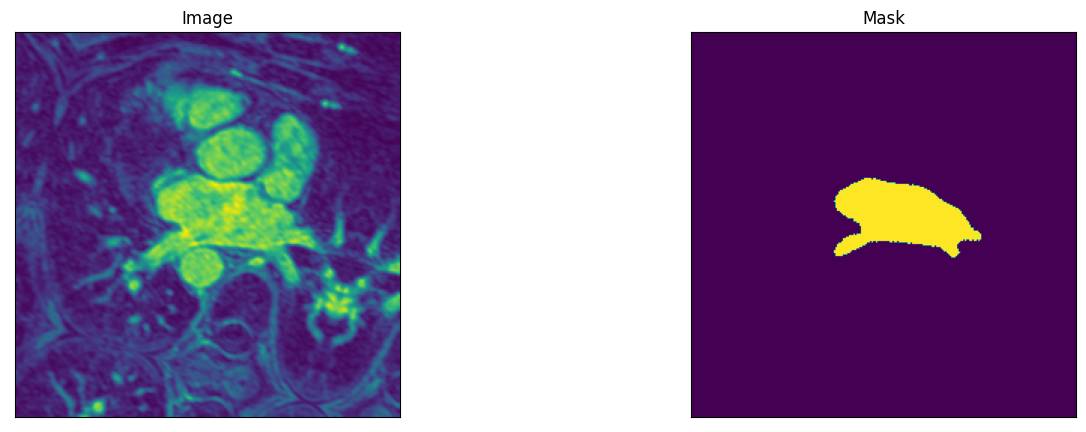

In [123]:
#### Visualize resulted augmented images and masks

# same image with different random transforms

augmented_dataset = AtriaDataset(DATA_DIR_TRAIN, training_dir,
                                 augmentation=get_training_augmentation(),preprocessing=get_preprocessing())


for i in range(2):
    image, mask = augmented_dataset[46]
    print(np.min(image), np.max(image), image.shape, type(image))
    print(np.min(mask), np.max(mask), mask.shape, type(mask))
    visualize(image=image, mask=mask)

In [124]:
import segmentation_models_pytorch as smp

In [125]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS,
    in_channels = 1,
    activation=ACTIVATION,
)
#preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [126]:
train_dataset = AtriaDataset(DATA_DIR_TRAIN, training_dir,
                                 augmentation=get_training_augmentation(),
                                 preprocessing=get_preprocessing())

valid_dataset = AtriaDataset(DATA_DIR_TRAIN, validation_dir,
                                 augmentation=get_training_augmentation(),
                                 preprocessing=get_preprocessing())

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=4)

In [127]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=1e-5),
])

In [128]:
import segmentation_models_pytorch.utils.metrics as smp_metrics
import segmentation_models_pytorch.utils.losses as smp_losses

In [129]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [131]:
# train model for 40 epochs

max_score = 0
num_epochs = 20
each_epoch_train_dice_loss = []
each_epoch_valid_dice_loss = []
each_epoch_train_iou_score = []
each_epoch_valid_iou_score = []
for epoch in range(num_epochs):
    
    print(f'Epoch {epoch+1}/{num_epochs}')
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    #if epoch == 24:
        #optimizer.param_groups[0]['lr'] = 1e-5
        #print('Decrease decoder learning rate to 1e-5!')
    
    each_epoch_train_dice_loss.append(train_logs['dice_loss'])
    each_epoch_valid_dice_loss.append(valid_logs['dice_loss'])
    each_epoch_train_iou_score.append(train_logs['iou_score'])
    each_epoch_valid_iou_score.append(valid_logs['iou_score'])

Epoch 1/20
valid: 100%|█████████████████| 440/440 [00:04<00:00, 93.94it/s, dice_loss - 0.7066, iou_score - 0.4444]
Model saved!
Epoch 2/20
valid: 100%|█████████████████| 440/440 [00:04<00:00, 93.35it/s, dice_loss - 0.5844, iou_score - 0.6224]
Model saved!
Epoch 3/20
valid: 100%|█████████████████| 440/440 [00:04<00:00, 93.40it/s, dice_loss - 0.5131, iou_score - 0.6385]
Model saved!
Epoch 4/20
valid: 100%|█████████████████| 440/440 [00:04<00:00, 93.63it/s, dice_loss - 0.4697, iou_score - 0.6564]
Model saved!
Epoch 5/20
valid: 100%|██████████████████| 440/440 [00:04<00:00, 93.89it/s, dice_loss - 0.462, iou_score - 0.6661]
Model saved!
Epoch 6/20
valid: 100%|█████████████████| 440/440 [00:04<00:00, 94.47it/s, dice_loss - 0.4493, iou_score - 0.6565]
Epoch 7/20
valid: 100%|█████████████████| 440/440 [00:04<00:00, 95.02it/s, dice_loss - 0.4518, iou_score - 0.6595]
Epoch 8/20
valid: 100%|█████████████████| 440/440 [00:04<00:00, 94.81it/s, dice_loss - 0.4439, iou_score - 0.6842]
Model saved!
Ep

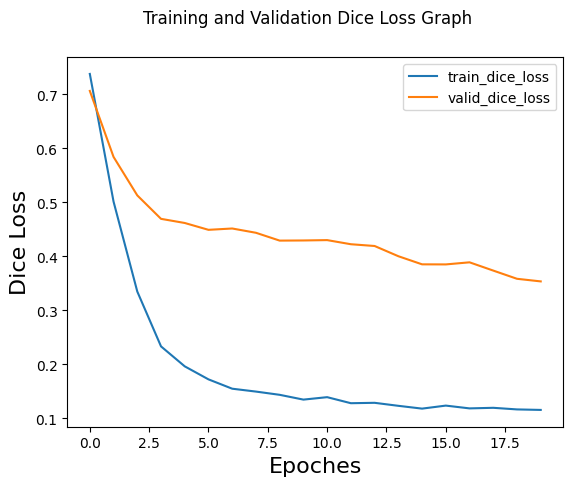

In [132]:
fig_loss = plt.figure()
fig_loss.suptitle("Training and Validation Dice Loss Graph")
plt.xlabel("Epoches", fontsize=16)
plt.ylabel("Dice Loss", fontsize=16)
plt.plot(each_epoch_train_dice_loss, label="train_dice_loss")
plt.plot(each_epoch_valid_dice_loss, label="valid_dice_loss")
plt.legend()
plt.show()
fig_loss.savefig("Training and Validation Dice Loss Graph_test_central.png")

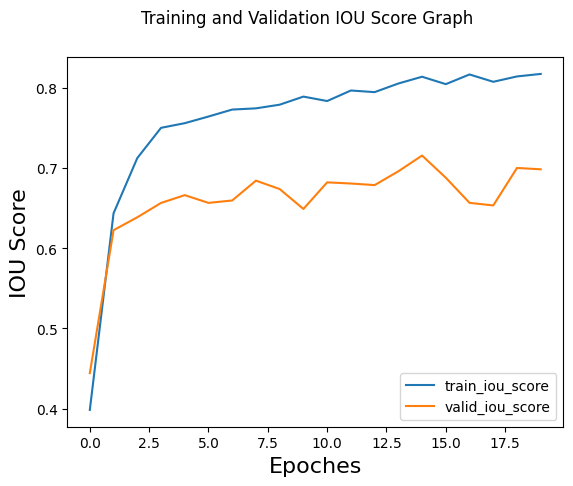

In [133]:
fig_iou = plt.figure()
fig_iou.suptitle("Training and Validation IOU Score Graph")
plt.xlabel("Epoches", fontsize=16)
plt.ylabel("IOU Score", fontsize=16)
plt.plot(each_epoch_train_iou_score, label="train_iou_score")
plt.plot(each_epoch_valid_iou_score, label="valid_iou_score")
plt.legend()
plt.show()
fig_iou.savefig("Training and Validation IOU Score Graph_test_central.png")

In [134]:
# load best saved checkpoint
best_model = torch.load('./best_model.pth')

In [135]:
# create test dataset
test_dataset = AtriaDataset(DATA_DIR_TEST, test_patient_list)

In [136]:
test_dataset_vis = AtriaDataset(DATA_DIR_TEST, test_patient_list,
                           augmentation=get_validation_augmentation(),
                           preprocessing=get_preprocessing())

test_dataloader = DataLoader(test_dataset_vis)

# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|████████████████| 4752/4752 [01:32<00:00, 51.25it/s, dice_loss - 0.3846, iou_score - 0.805]


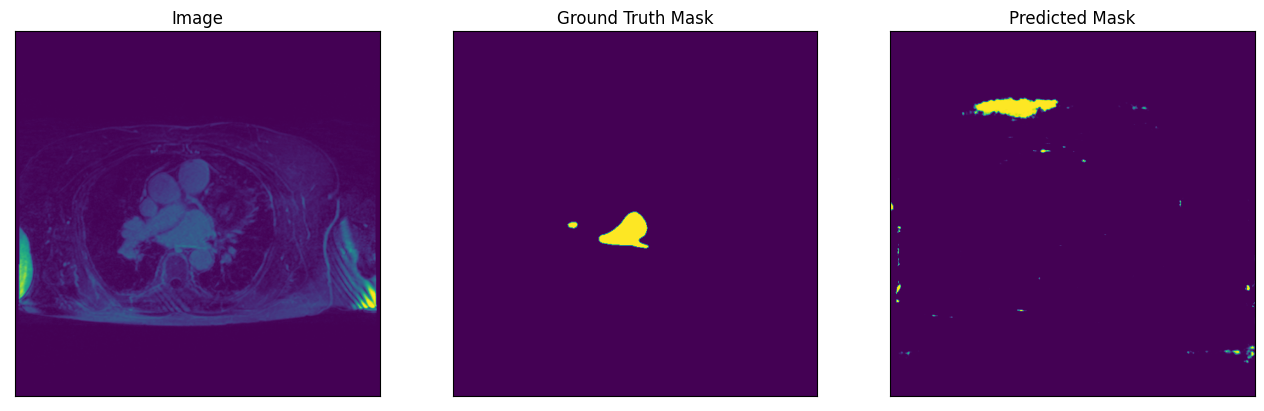

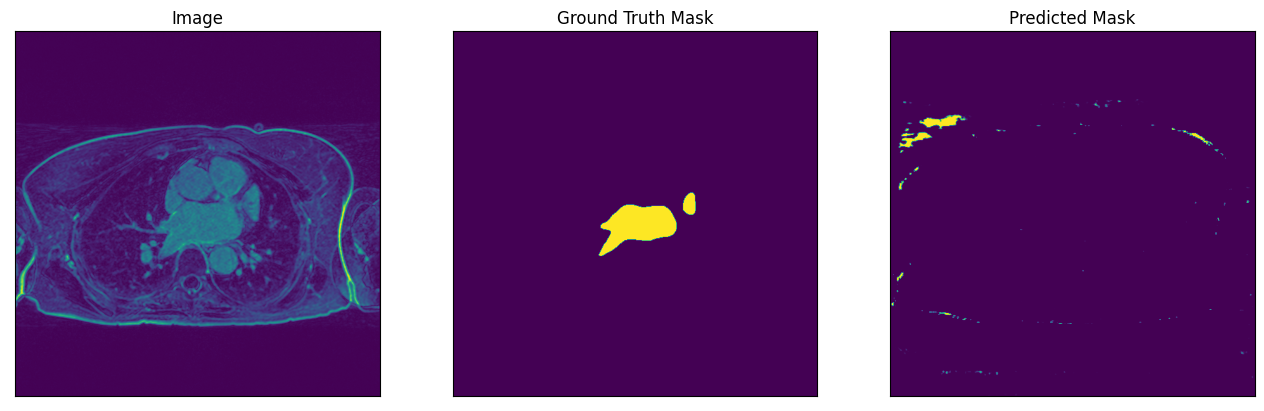

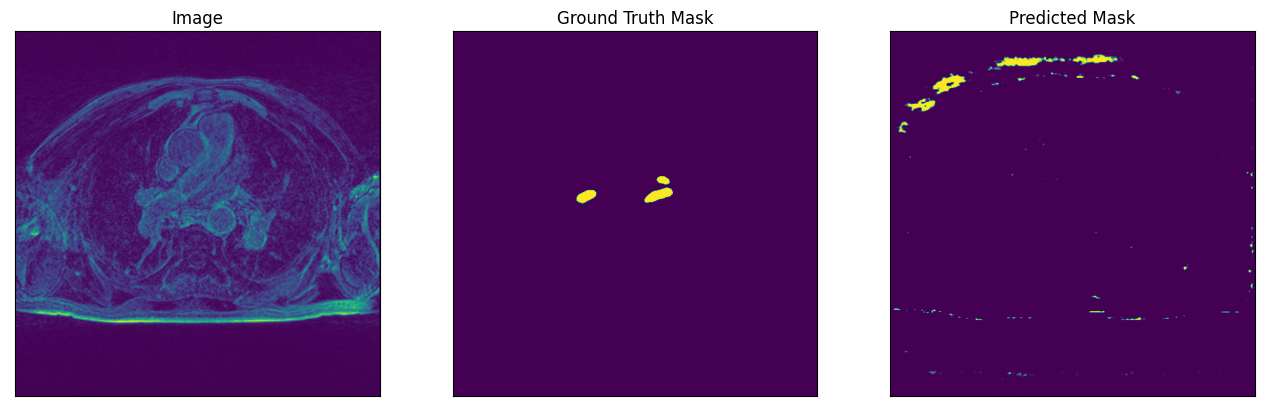

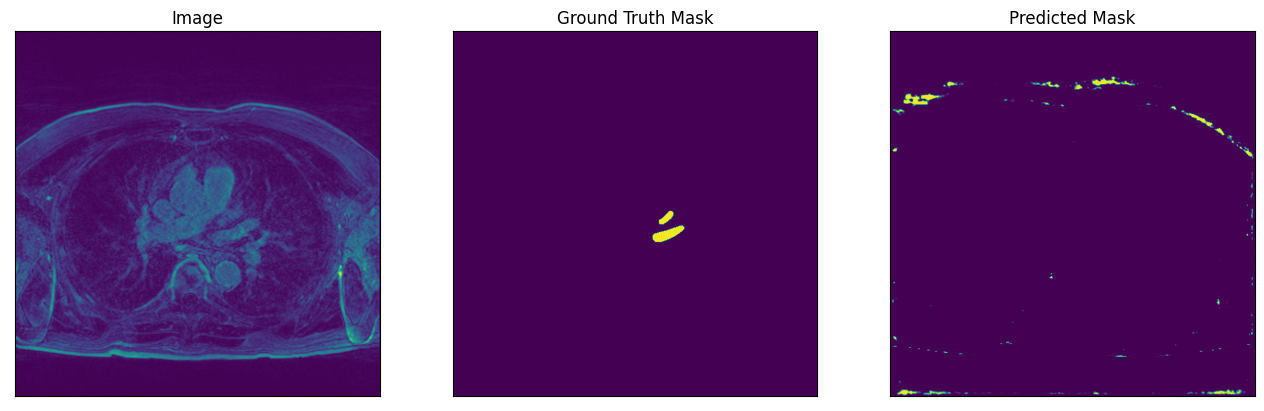

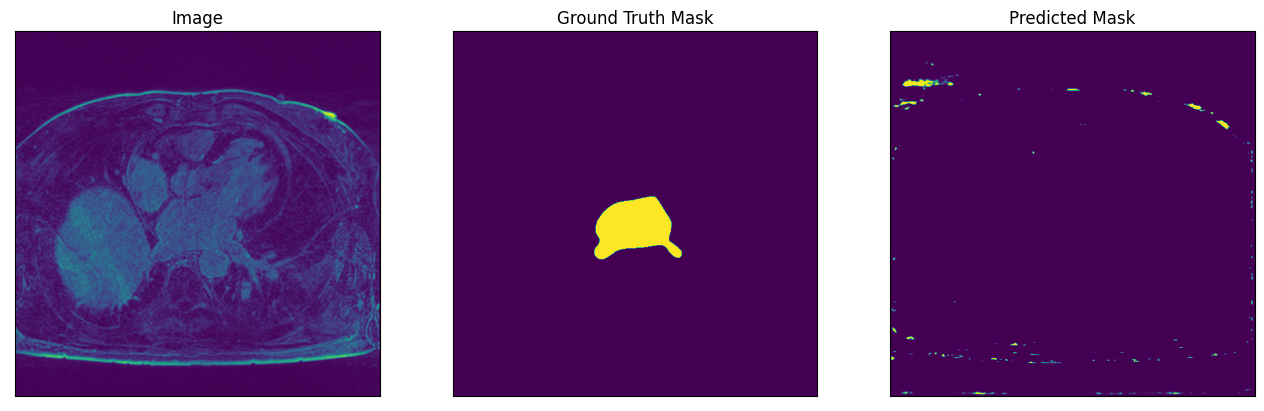

In [144]:
train_dataset = AtriaDataset(DATA_DIR_TRAIN, training_dir,
                                 augmentation=get_training_augmentation(),
                                 preprocessing=get_preprocessing())

for i in range(5):
    n = np.random.choice(len(test_dataset))
    #n = 43
    image_vis = test_dataset[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    gt_mask = gt_mask.squeeze()
    
    image = image.transpose(2,0,1).astype("float32")

    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )

torch.Size([1, 1, 576, 576])
torch.Size([1, 1, 576, 576])


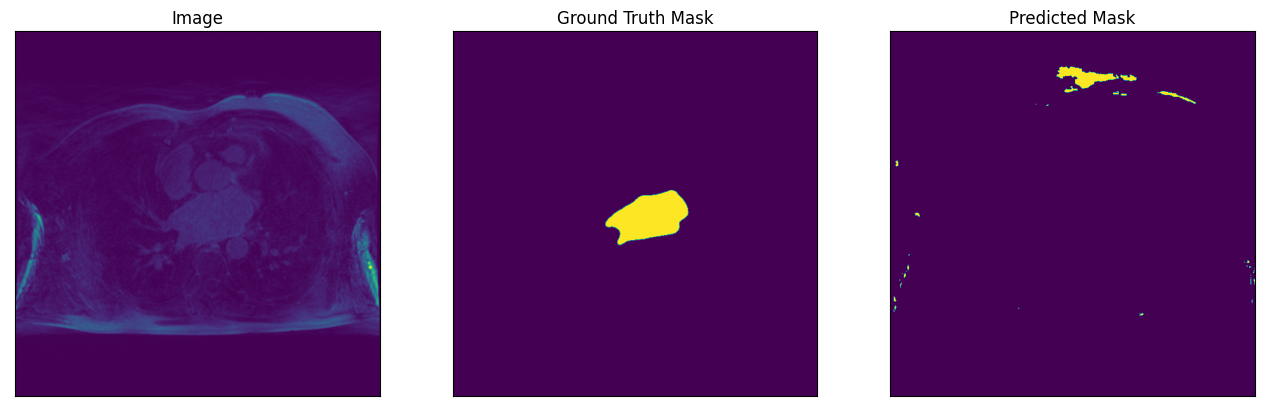

torch.Size([1, 1, 576, 576])
torch.Size([1, 1, 576, 576])


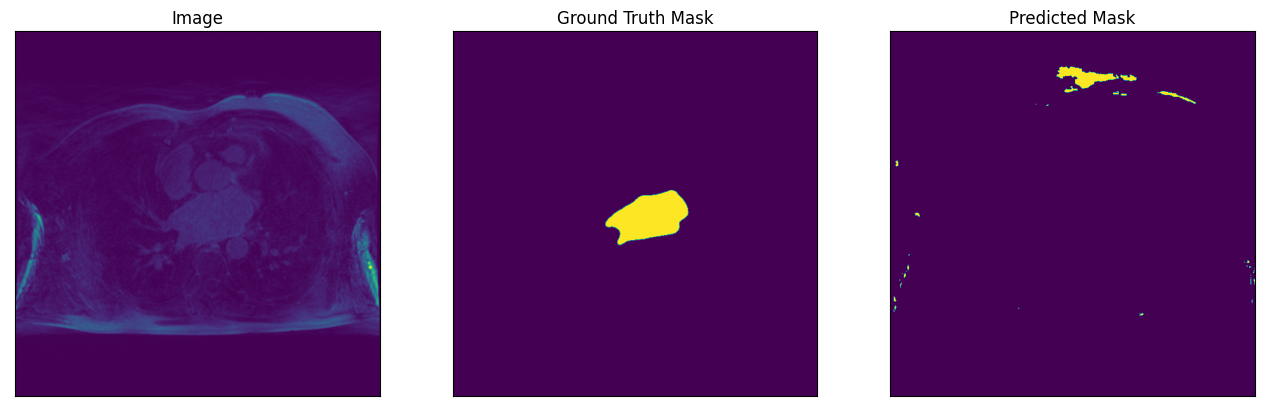

torch.Size([1, 1, 576, 576])
torch.Size([1, 1, 576, 576])


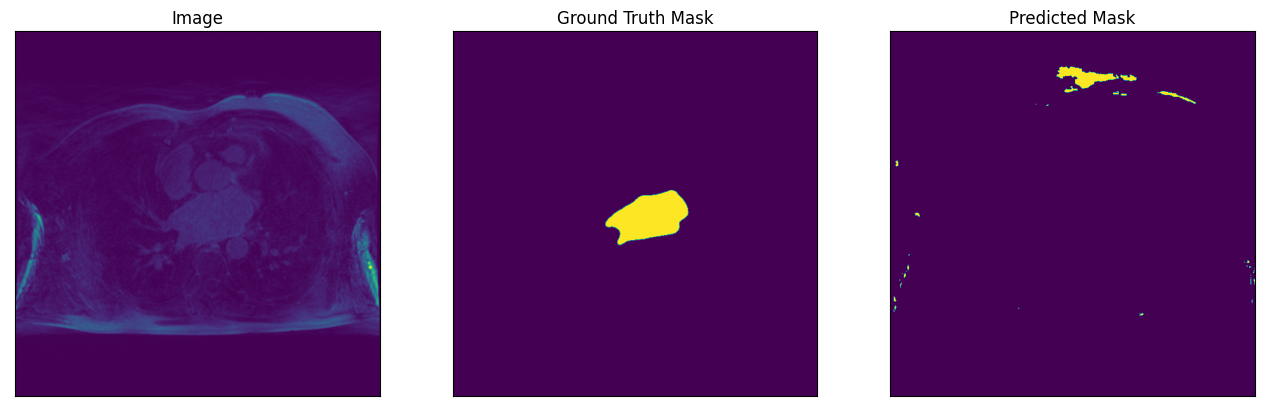

torch.Size([1, 1, 576, 576])
torch.Size([1, 1, 576, 576])


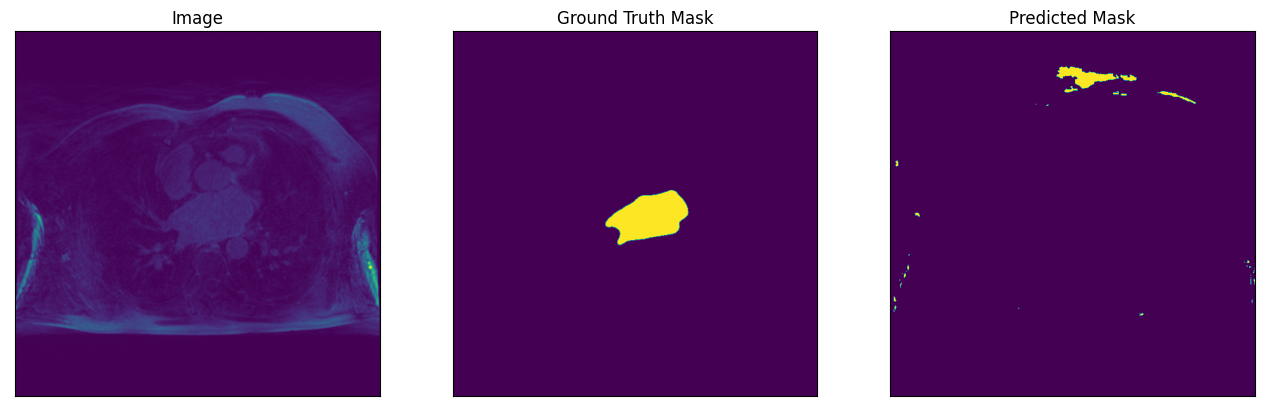

torch.Size([1, 1, 576, 576])
torch.Size([1, 1, 576, 576])


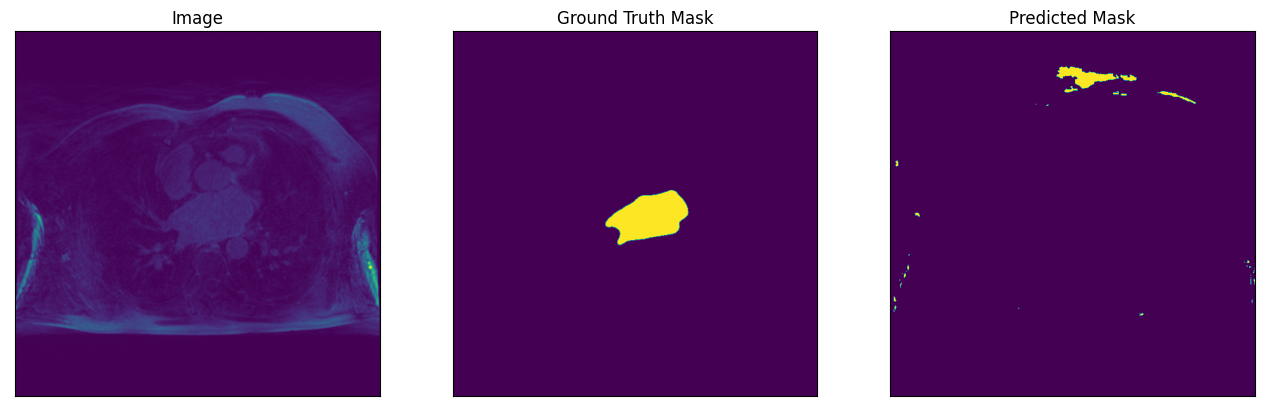

In [148]:
for i in range(5):
    #n = np.random.choice(len(test_dataset))
    n = 43
    image_vis = test_dataset[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    gt_mask = gt_mask.squeeze()
    
    image = image.transpose(2,0,1).astype("float32")
    best_model = best_model.eval()
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    print(x_tensor.shape)
    pr_mask = best_model(x_tensor)
    print(pr_mask.shape)
    pr_mask = (pr_mask.detach().squeeze().cpu().numpy().round())
    
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )
    #plt.imshow(pr_mask)

In [141]:
for i in range(5):
    #n = np.random.choice(len(test_dataset))
    n = 43
    image_vis = train_dataset[n][0].astype('uint8')
    image, gt_mask = train_dataset[n]
    gt_mask = gt_mask.squeeze()
    
    image = image.transpose(2,0,1).astype("float32")

    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    print(x_tensor.shape)
    pr_mask = best_model.predict(x_tensor)
    print(pr_mask.shape)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )

torch.Size([1, 256, 1, 256])


RuntimeError: Wrong input shape height=1, width=256. Expected image height and width divisible by 32. Consider pad your images to shape (32, 256).